**This notebook is an exercise in the [Introduction to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/machine-learning-competitions).**

---

# Introduction

In this exercise, you will create and submit predictions for a Kaggle competition. You can then improve your model (e.g. by adding features) to apply what you've learned and move up the leaderboard.

Begin by running the code cell below to set up code checking and the filepaths for the dataset.

In [1]:
# Set up code checking
from learntools.core import binder
binder.bind(globals())
from learntools.machine_learning.ex7 import *

# Set up filepaths
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv")

Here's some of the code you've written so far. Start by running it again.

In [2]:
# Import helpful libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder


# Load the data, and separate the target
iowa_file_path = '../input/train.csv'
home_data = pd.read_csv(iowa_file_path)

In [3]:
# path to file you will use for predictions
test_data_path = '../input/test.csv'

# read test data file using pandas
test_data = pd.read_csv(test_data_path)

# Results default model

First 15 predictions:

[122657.0,
 156789.0,
 182959.0,
 178102.0,
 189049.0,
 180979.0,
 172797.0,
 173717.0,
 187535.0,
 116172.0,
 190798.0,
 93823.0,
 89249.0,
 145111.0,
 124696.0]
 
Validation MAE for DEFAULT Random Forest Model: **21,857**

# Model optimization

· Will clean the dataset, hot-code categorical features, scale numerical features, and train a new model

## Defining functions

In [4]:
def drop_columns_nan(dataframe, threshold: int) -> pd.DataFrame:
  """Drops columns from a DataFrame that contain a certain amount of missing values (NaNs).

  Args:
      dataframe: The pandas DataFrame to process.
      threshold: The minimum number of NaNs a column must have to be dropped.
          A column will be dropped if the number of NaNs is greater than or equal to this threshold.

  Returns:
      The modified DataFrame with columns containing a high number of NaNs dropped.
  """
  columns_to_drop = [col for col in dataframe.columns if dataframe[col].isnull().sum() >= threshold]
  dataframe.drop(columns_to_drop, axis=1, inplace=True)

####################################################################################################

def drop_notinformative(df, threshold=0.95):
    """  drop columns with high percentage of ONE UNIQUE value
    """
    
    columns_to_drop = []
    threshold = 0.9
    for col in df.columns:
        value_counts = df[col].value_counts(normalize=True)
        if len(value_counts) == 1 or value_counts.iloc[0] > threshold:  # Check for single value or exceeding threshold
            columns_to_drop.append(col)

    df.drop(columns_to_drop, axis=1, inplace=True)
  

#################################################################################################

def impute_nan_custom(df, method_numerical='mean', value_categorical='Non-existent', fill_categorical_with_mode=False):
  """
  Imputes missing values in a DataFrame with user-defined options

  Args:
      df (pandas.DataFrame): The DataFrame to impute
      method_numerical (str, optional): Method to impute numerical columns. Defaults to 'mean'. Valid options are 'mean', 'median', 'zero', or 'mode'.
      value_categorical (str, optional): Value to use for imputing missing values in categorical columns. Defaults to 'Non-existent'.
      fill_categorical_with_mode (bool, optional): If True, fills missing values in categorical columns with the mode. Defaults to False.

  Returns:
      pandas.DataFrame: The DataFrame with imputed missing values
      list: A list of columns containing missing values

  Raises:
      ValueError: If an invalid method_numerical is provided.
  """
  columns_with_nan = []
  for col in df.columns:
    if df[col].isnull().sum() > 0 and df[col].dtype.kind in ['f', 'i']:  # Check for float or integer
      if method_numerical == 'mean':
        df[col] = df[col].fillna(value=df[col].mean())
      elif method_numerical == 'median':
        df[col] = df[col].fillna(value=df[col].median())
      elif method_numerical == 'zero':
        df[col] = df[col].fillna(value=0)
      elif method_numerical == 'mode':
        df[col] = df[col].fillna(value=df[col].mode()[0])
      else:
        raise ValueError(f"Invalid method_numerical: {method_numerical}. Valid options are 'mean', 'median', 'zero', or 'mode'.")
      columns_with_nan.append(col)
    elif df[col].isnull().sum() > 0 and fill_categorical_with_mode and pd.api.types.is_categorical_dtype(df[col]):
      df[col] = df[col].fillna(value=df[col].mode()[0])  # Fill with mode for categorical
      columns_with_nan.append(col)
    elif df[col].isnull().sum() > 0:
      df[col] = df[col].fillna(value=value_categorical)
      columns_with_nan.append(col)
  return columns_with_nan

#################################################################################################

def replace_less_frequent(df: pd.DataFrame, list_col: list[str], threshold: float = 0.02, new_value='other') -> pd.DataFrame:
  """Replaces less frequent values in specified columns of a DataFrame with a new value.

  This function identifies values that appear less frequently than a certain threshold
  within specified columns of a DataFrame and replaces them with a new user-defined value.
  It also prints value counts to confirm the changes.

  Args:
      df: The pandas DataFrame to process.
      list_col: A list of column names to be processed.
      threshold: The minimum frequency (between 0 and 1) a value must have to be considered
          frequent. Values with frequency less than the threshold will be replaced.
      new_value: The value to use for replacing less frequent values.

  Returns:
      The modified DataFrame with less frequent values replaced.

  Prints:
      Value counts for each modified column after the replacement.
  """

  vals_to_change = []

  # Iterate over each column in the list
  for col in list_col:
    # Get values with frequency less than the threshold
    filtered_values = df[col].value_counts(normalize=True)
    filtered_values = filtered_values[filtered_values < threshold].index.tolist()
    vals_to_change.extend(filtered_values)  # Extend to avoid nested lists

  # Replace less frequent values with new_value
  for col in list_col:
    df[col] = np.where(df[col].isin(vals_to_change), new_value, df[col])

  # Print value counts for each modified column
  for col in list_col:
    print(f"\nValue Counts for {col} after replacement:")
    print(df[col].value_counts(normalize=True, dropna=False))
    print(f"\n** NEW {col} created correctly**")


#######################################################################################################

def get_categorical(df):
  """
  Identifies categorical columns in a DataFrame

  Args:
      df (pandas.DataFrame): The DataFrame to identify categorical columns in

  Returns:
      list: A list containing the names of categorical columns
  """
  l_cat = []
  for col in df.columns:
    if df[col].dtype.kind == 'O':  # Check for object dtype (categorical)
      l_cat.append(col)
  return l_cat

#######################################################################################################

def get_numeric(df):
  """
  Identifies categorical columns in a DataFrame

  Args:
      df (pandas.DataFrame): The DataFrame to identify categorical columns in

  Returns:
      list: A list containing the names of categorical columns
  """
  l_num = []
  for col in df.columns:
    if df[col].dtype.kind == 'f' or df[col].dtype.kind == 'i':  # Check for object dtype (categorical)
      l_num.append(col)
  return l_num

#######################################################################################################

def get_posible_bool(df):
  """
  Identifies categorical columns in a DataFrame

  Args:
      df (pandas.DataFrame): The DataFrame to identify categorical columns in

  Returns:
      list: A list containing the names of categorical columns
  """
  l_bool = []
  for col in df.columns:
    if len(df[col].unique()) == 2:  # Check for object dtype (categorical)
      l_bool.append(col)
  return l_bool

## Cleaning dataset

In [5]:
import pandas as pd
import numpy as np

In [6]:
pd.set_option('display.max_rows', None)

In [7]:
home_data2 = home_data.copy()
home_data2.set_index('Id', inplace=True)

In [8]:
home_data2.isnull().sum()

MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

In [9]:
# Drop columns with more than 200 NaNs
drop_columns_nan(home_data2, threshold=300)

In [10]:
#Inspect remaining columns with NaNs
columns_with_nan = []

for col in home_data2.columns:
    if home_data2[col].isnull().sum() > 0:
        columns_with_nan.append(col)

home_data2[columns_with_nan].head(20)

,LotFrontage,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
Id,,,,,,,,,,,,,
1,65.0,196.0,Gd,TA,No,GLQ,Unf,SBrkr,Attchd,2003.0,RFn,TA,TA
2,80.0,0.0,Gd,TA,Gd,ALQ,Unf,SBrkr,Attchd,1976.0,RFn,TA,TA
3,68.0,162.0,Gd,TA,Mn,GLQ,Unf,SBrkr,Attchd,2001.0,RFn,TA,TA
4,60.0,0.0,TA,Gd,No,ALQ,Unf,SBrkr,Detchd,1998.0,Unf,TA,TA
5,84.0,350.0,Gd,TA,Av,GLQ,Unf,SBrkr,Attchd,2000.0,RFn,TA,TA
6,85.0,0.0,Gd,TA,No,GLQ,Unf,SBrkr,Attchd,1993.0,Unf,TA,TA
7,75.0,186.0,Ex,TA,Av,GLQ,Unf,SBrkr,Attchd,2004.0,RFn,TA,TA
8,NaN,240.0,Gd,TA,Mn,ALQ,BLQ,SBrkr,Attchd,1973.0,RFn,TA,TA
9,51.0,0.0,TA,TA,No,Unf,Unf,FuseF,Detchd,1931.0,Unf,Fa,TA


In [11]:
# fill NaNs in MasVnrArea (to 0), GarageYrBlt (to YearBuilt), LotFrontage to mean

home_data2['MasVnrArea'] = home_data2['MasVnrArea'].fillna(0)
home_data2['GarageYrBlt'] = home_data2['GarageYrBlt'].fillna(home_data2['YearBuilt'])
home_data2['LotFrontage'] = home_data2['LotFrontage'].fillna(home_data2['LotFrontage'].mean())

In [12]:
#import matplotlib.pyplot as plt
#plt.scatter(x = home_data2['YearBuilt'], y = home_data2['GarageYrBlt'])

In [13]:
home_data3 = home_data2.copy()

for col in home_data3.columns:
    if home_data3[col].isnull().sum() > 0:
        print(home_data3[col].value_counts(normalize=True, dropna=False))

BsmtQual
TA     0.444521
Gd     0.423288
Ex     0.082877
NaN    0.025342
Fa     0.023973
Name: proportion, dtype: float64
BsmtCond
TA     0.897945
Gd     0.044521
Fa     0.030822
NaN    0.025342
Po     0.001370
Name: proportion, dtype: float64
BsmtExposure
No     0.652740
Av     0.151370
Gd     0.091781
Mn     0.078082
NaN    0.026027
Name: proportion, dtype: float64
BsmtFinType1
Unf    0.294521
GLQ    0.286301
ALQ    0.150685
BLQ    0.101370
Rec    0.091096
LwQ    0.050685
NaN    0.025342
Name: proportion, dtype: float64
BsmtFinType2
Unf    0.860274
Rec    0.036986
LwQ    0.031507
NaN    0.026027
BLQ    0.022603
ALQ    0.013014
GLQ    0.009589
Name: proportion, dtype: float64
Electrical
SBrkr    0.913699
FuseA    0.064384
FuseF    0.018493
FuseP    0.002055
Mix      0.000685
NaN      0.000685
Name: proportion, dtype: float64
GarageType
Attchd     0.595890
Detchd     0.265068
BuiltIn    0.060274
NaN        0.055479
Basment    0.013014
CarPort    0.006164
2Types     0.004110
Name: propo

In [14]:
# if GarageType = NaN, no garage
# drop BsmtExposure and BsmtFinType2 cause they dont match other basements

home_data3['GarageType'] = home_data3['GarageType'].fillna('non-existent')
del(home_data3['BsmtExposure'])
del(home_data3['BsmtFinType2'])

In [15]:
# Impute remaining NaNs
impute_nan_custom(home_data3, method_numerical='mean', value_categorical='non-existent', fill_categorical_with_mode=True)

/tmp/ipykernel_18/605756754.py:64: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif df[col].isnull().sum() > 0 and fill_categorical_with_mode and pd.api.types.is_categorical_dtype(df[col]):


['BsmtQual',
 'BsmtCond',
 'BsmtFinType1',
 'Electrical',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [16]:
home_data3.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
GarageType  

# drop not informative and group low frequent categories into 'other' category

In [17]:
home_data4 = home_data3.copy()
#remove low informative
drop_notinformative(home_data4, threshold=0.9)

In [18]:
#Replace less frequent
replace_less_frequent(home_data4, list_col=get_categorical(home_data4), threshold=0.03, new_value='other')


Value Counts for MSZoning after replacement:
MSZoning
RL       0.788356
RM       0.149315
FV       0.044521
other    0.017808
Name: proportion, dtype: float64

** NEW MSZoning created correctly**

Value Counts for LotShape after replacement:
LotShape
Reg      0.633562
IR1      0.331507
other    0.034932
Name: proportion, dtype: float64

** NEW LotShape created correctly**

Value Counts for LandContour after replacement:
LandContour
Lvl      0.897945
Bnk      0.043151
HLS      0.034247
other    0.024658
Name: proportion, dtype: float64

** NEW LandContour created correctly**

Value Counts for LotConfig after replacement:
LotConfig
Inside     0.720548
Corner     0.180137
CulDSac    0.064384
FR2        0.032192
other      0.002740
Name: proportion, dtype: float64

** NEW LotConfig created correctly**

Value Counts for Neighborhood after replacement:
Neighborhood
other      0.182192
NAmes      0.154110
CollgCr    0.102740
OldTown    0.077397
Edwards    0.068493
Somerst    0.058904
Gilbert

# can new variables be created or modified?

In [19]:
#MSSubClass to string
home_data4['MSSubClass'] = home_data4['MSSubClass'].astype(str)

In [20]:
home_data4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 54 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   Neighborhood   1460 non-null   object 
 8   Condition1     1460 non-null   object 
 9   BldgType       1460 non-null   object 
 10  HouseStyle     1460 non-null   object 
 11  OverallQual    1460 non-null   int64  
 12  OverallCond    1460 non-null   int64  
 13  YearBuilt      1460 non-null   int64  
 14  YearRemodAdd   1460 non-null   int64  
 15  RoofStyle      1460 non-null   object 
 16  Exterior1st    1460 non-null   object 
 17  Exterior2nd    1460 non-null   object 
 18  MasVnrArea   

## Hot-code categorical features and scale numerical features

In [21]:
"""l_num = []
for col in home_data4.columns:
    if 'Year' not in col and 'Yr' not in col:  # Exclude columns with 'Year' or 'Yr'
        if home_data4[col].dtype.kind in ['i', 'f']:  # Check if column is numeric (integer or float)
            if len(home_data4[col].unique()) > 10:  # Check if numeric column has 4 or fewer unique values
                if col != 'SalePrice':
                    l_num.append(col)"""

"l_num = []\nfor col in home_data4.columns:\n    if 'Year' not in col and 'Yr' not in col:  # Exclude columns with 'Year' or 'Yr'\n        if home_data4[col].dtype.kind in ['i', 'f']:  # Check if column is numeric (integer or float)\n            if len(home_data4[col].unique()) > 10:  # Check if numeric column has 4 or fewer unique values\n                if col != 'SalePrice':\n                    l_num.append(col)"

In [22]:
"""Minmax scale of numeric variables
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
      
# scale numerical variables
home_data4[l_num] = scaler.fit_transform(home_data4[l_num])"""

'Minmax scale of numeric variables\nfrom sklearn.preprocessing import MinMaxScaler\nscaler = MinMaxScaler()\n      \n# scale numerical variables\nhome_data4[l_num] = scaler.fit_transform(home_data4[l_num])'

# Target encoding of categorical variables with more than 4 categories

In [23]:
#home_data5 = home_data4.copy()

In [24]:
""" Drop the target variable from X
X = home_data5.drop('SalePrice', axis=1)
y = home_data5['SalePrice']

# Initialize an empty dictionary to store encoders for later use
encoders = {}

# Target encode categorical variables with more than 3 unique values
for col in X.select_dtypes(include=['object']).columns:
    if len(X[col].unique()) > 3:
        # Initialize the encoder
        encoder = TargetEncoder()
        # Fit the encoder
        encoder.fit(X[col], y)
        # Store the trained encoder
        encoders[col] = encoder"""

" Drop the target variable from X\nX = home_data5.drop('SalePrice', axis=1)\ny = home_data5['SalePrice']\n\n# Initialize an empty dictionary to store encoders for later use\nencoders = {}\n\n# Target encode categorical variables with more than 3 unique values\nfor col in X.select_dtypes(include=['object']).columns:\n    if len(X[col].unique()) > 3:\n        # Initialize the encoder\n        encoder = TargetEncoder()\n        # Fit the encoder\n        encoder.fit(X[col], y)\n        # Store the trained encoder\n        encoders[col] = encoder"

In [25]:
""" Apply the trained encoders from 'home_data5' to 'home_data5'
for col, encoder in encoders.items():
    if col in home_data5.columns:
        home_data5[col] = encoder.transform(home_data5[col])"""

" Apply the trained encoders from 'home_data5' to 'home_data5'\nfor col, encoder in encoders.items():\n    if col in home_data5.columns:\n        home_data5[col] = encoder.transform(home_data5[col])"

# Dummies

In [26]:
# create dummy variables
home_data_dummies = pd.get_dummies(home_data4, columns=get_categorical(home_data4), dtype='int32')

## Optimizing model

### Cleaning test data

In [27]:
test_data = pd.read_csv(test_data_path)
test_data.set_index('Id', inplace=True)

In [28]:
drop_columns_nan(test_data, threshold=300)

test_data['MasVnrArea'] = test_data['MasVnrArea'].fillna(0)
test_data['GarageYrBlt'] = test_data['GarageYrBlt'].fillna(test_data['YearBuilt'])
#test_data['LotFrontage'] = test_data['LotFrontage'].fillna(test_data['LotFrontage'].mean())

test_data['GarageType'] = test_data['GarageType'].fillna('non-existent')
del(test_data['BsmtExposure'])
del(test_data['BsmtFinType2'])

impute_nan_custom(test_data, method_numerical='mean', value_categorical='non-existent', fill_categorical_with_mode=True)

drop_notinformative(test_data, threshold=0.9)

replace_less_frequent(test_data, list_col=get_categorical(test_data), threshold=0.03, new_value='other')

test_data['MSSubClass'] = test_data['MSSubClass'].astype(str)

test_data_dummies = pd.get_dummies(test_data, columns=get_categorical(test_data), dtype='int32')


Value Counts for MSZoning after replacement:
MSZoning
RL       0.763537
RM       0.165867
FV       0.050720
other    0.019877
Name: proportion, dtype: float64

** NEW MSZoning created correctly**

Value Counts for LotShape after replacement:
LotShape
Reg      0.640164
IR1      0.331734
other    0.028101
Name: proportion, dtype: float64

** NEW LotShape created correctly**

Value Counts for LandContour after replacement:
LandContour
Lvl      0.898561
HLS      0.047978
Bnk      0.037012
other    0.016450
Name: proportion, dtype: float64

** NEW LandContour created correctly**

Value Counts for LotConfig after replacement:
LotConfig
Inside     0.740918
Corner     0.169979
CulDSac    0.056203
other      0.032899
Name: proportion, dtype: float64

** NEW LotConfig created correctly**

Value Counts for Neighborhood after replacement:
Neighborhood
NAmes      0.149417
other      0.143249
OldTown    0.086361
CollgCr    0.080192
Somerst    0.065798
Edwards    0.064428
NridgHt    0.061001
Gilbert

/tmp/ipykernel_18/605756754.py:64: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif df[col].isnull().sum() > 0 and fill_categorical_with_mode and pd.api.types.is_categorical_dtype(df[col]):


In [29]:
test_data_dummies.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,PavedDrive_Y,PavedDrive_other,SaleType_COD,SaleType_New,SaleType_WD,SaleType_other,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_other
Id,,,,,,,,,,,,,,,,,,,,,
1461,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,...,1,0,0,0,1,0,0,1,0,0
1462,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,...,1,0,0,0,1,0,0,1,0,0
1463,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,...,1,0,0,0,1,0,0,1,0,0
1464,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,...,1,0,0,0,1,0,0,1,0,0
1465,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,...,1,0,0,0,1,0,0,1,0,0


# XGBoost model

In [30]:
common_columns = list(set(home_data_dummies.columns).intersection(test_data_dummies.columns))

<Axes: >

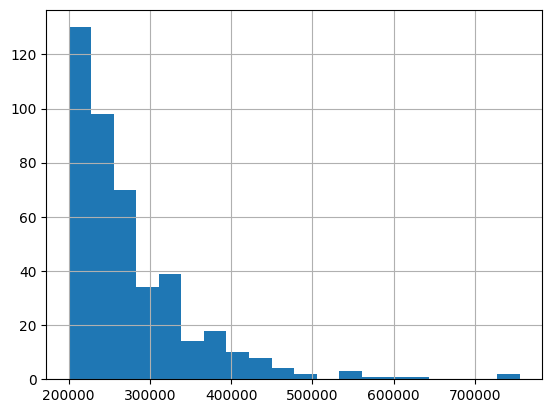

In [31]:
home_data_dummies[home_data_dummies['SalePrice'] >= 200000].SalePrice.hist(bins=20)

In [32]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from xgboost import XGBRegressor

# Assuming home_data_dummies is your prepared DataFrame

# Split data into features (X) and target (y)
home_data_dummies = home_data_dummies[home_data_dummies['SalePrice'] <= 400000] #To exclude outliers
X = home_data_dummies[common_columns]  # Assuming common_columns excludes SalePrice
y = home_data_dummies.SalePrice

"""
# Split data into training and testing sets (adjust test_size as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Define XGBoost model parameters for hyperparameter tuning
xgb_model = XGBRegressor(random_state=1)
param_grid = {
    'eta': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 8],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0.1, 1.0, 10.0],
    'reg_lambda': [1.0, 10.0, 100.0]
}

# Use RandomizedSearchCV for hyperparameter tuning (adjust n_iter)
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=1)
random_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

print("Best XGBoost Hyperparameters:", best_params)

# Make predictions on the testing set
y_pred = best_model.predict(X_test)

# Evaluate model performance (e.g., using mean squared error)
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
print("Root Mean Squared Error (RMSE):", rmse)
mae = mean_absolute_error(y_test, y_pred)  # Root Mean Squared Error
print("Mean Absolute Error (MAE):", mae)
"""

'\n# Split data into training and testing sets (adjust test_size as needed)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)\n\n# Define XGBoost model parameters for hyperparameter tuning\nxgb_model = XGBRegressor(random_state=1)\nparam_grid = {\n    \'eta\': [0.1, 0.05, 0.01],\n    \'max_depth\': [3, 5, 8],\n    \'n_estimators\': [100, 200, 300],\n    \'subsample\': [0.8, 1.0],\n    \'colsample_bytree\': [0.6, 0.8, 1.0],\n    \'reg_alpha\': [0.1, 1.0, 10.0],\n    \'reg_lambda\': [1.0, 10.0, 100.0]\n}\n\n# Use RandomizedSearchCV for hyperparameter tuning (adjust n_iter)\nrandom_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=100, cv=5, scoring=\'neg_mean_squared_error\', random_state=1)\nrandom_search.fit(X_train, y_train)\n\n# Get the best model and its parameters\nbest_model = random_search.best_estimator_\nbest_params = random_search.best_params_\n\nprint("Best XGBoost Hyperparameters:", best_params)\n\

In [33]:
best_params = {'colsample_bytree': 0.6, 'eta': 0.05, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 10.0, 'reg_lambda': 1.0, 'subsample': 0.8}

In [34]:
#Train on full train data

xgb_model = XGBRegressor(random_state=1, **best_params)
xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [35]:
#Predict 

test_preds_model_boost = xgb_model.predict(test_data_dummies[common_columns])

print(test_preds_model_boost[0:15].round(0).tolist())

# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Id': test_data.index,
                       'SalePrice': test_preds_model_boost})
output.to_csv('submission_v15.csv', index=False)

[119087.0, 160880.0, 180599.0, 191063.0, 182763.0, 174983.0, 171939.0, 166932.0, 176827.0, 126321.0, 208257.0, 95599.0, 100497.0, 155936.0, 145982.0]


# %% [markdown]
# # Train a new model

# %% [code] {"execution":{"iopub.status.busy":"2024-05-15T22:54:33.884700Z","iopub.execute_input":"2024-05-15T22:54:33.885423Z","iopub.status.idle":"2024-05-15T22:54:33.890331Z","shell.execute_reply.started":"2024-05-15T22:54:33.885391Z","shell.execute_reply":"2024-05-15T22:54:33.889099Z"}}
high_corr_features_unique_test = set(test_data_dummies.columns).intersection(high_corr_features_unique)

# %% [code] {"execution":{"iopub.status.busy":"2024-05-15T22:54:33.892083Z","iopub.execute_input":"2024-05-15T22:54:33.892398Z","iopub.status.idle":"2024-05-15T22:54:33.903364Z","shell.execute_reply.started":"2024-05-15T22:54:33.892362Z","shell.execute_reply":"2024-05-15T22:54:33.902418Z"}}
common_columns = list(set(home_data_dummies[list(high_corr_features_unique)].columns).intersection(test_data_dummies[list(high_corr_features_unique_test)].columns))

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2024-05-15T22:54:33.904447Z","iopub.execute_input":"2024-05-15T22:54:33.904733Z","iopub.status.idle":"2024-05-15T22:54:33.910276Z","shell.execute_reply.started":"2024-05-15T22:54:33.904710Z","shell.execute_reply":"2024-05-15T22:54:33.909058Z"}}
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# %% [code] {"execution":{"iopub.status.busy":"2024-05-15T22:54:33.911856Z","iopub.execute_input":"2024-05-15T22:54:33.912660Z","iopub.status.idle":"2024-05-15T22:54:33.922805Z","shell.execute_reply.started":"2024-05-15T22:54:33.912621Z","shell.execute_reply":"2024-05-15T22:54:33.921806Z"}}
"""
#X = home_data_dummies.drop(['SalePrice'], axis=1)
#X = home_data_dummies[list(high_corr_features_unique)]
X = home_data_dummies[common_columns]
y = home_data_dummies['SalePrice']

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

for max_leaf_nodes in range(10, 10000, 50):
    rf_model = RandomForestRegressor(random_state=1, max_leaf_nodes=max_leaf_nodes)
    rf_model.fit(train_X, train_y)
    rf_val_predictions = rf_model.predict(val_X)
    rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)
    
    print("Max leaf nodes: %d \t\t Mean Absolute Error: %d" %(max_leaf_nodes, rf_val_mae))
    
    if rf_val_mae < 15000:
        print("Stopping criteria reached.")
        break"""

# %% [code] {"execution":{"iopub.status.busy":"2024-05-15T22:54:33.969333Z","iopub.execute_input":"2024-05-15T22:54:33.969685Z","iopub.status.idle":"2024-05-15T22:54:33.977405Z","shell.execute_reply.started":"2024-05-15T22:54:33.969659Z","shell.execute_reply":"2024-05-15T22:54:33.976193Z"}}
"""
X = home_data_dummies[common_columns]
#X = home_data_dummies.drop(['SalePrice'], axis=1)
y = home_data_dummies.SalePrice

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Define hyperparameters to explore
n_estimators_list = [50, 100, 150, 200]  # Add more values
max_depth_list = [None, 10, 20, 30]  # Add more values
min_samples_split_list = [2, 5, 10, 15]  # Add more values

best_mae = float('inf')
best_hyperparameters = {}

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for min_samples_split in min_samples_split_list:
            rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=1, max_leaf_nodes=200)
            rf_model.fit(train_X, train_y)
            rf_val_predictions = rf_model.predict(val_X)
            rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)
            
            print("n_estimators: {}, max_depth: {}, min_samples_split: {} \t\t Mean Absolute Error: {}".format(n_estimators, max_depth, min_samples_split, rf_val_mae))
            
            if rf_val_mae < best_mae:
                best_mae = rf_val_mae
                best_hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split}

print("\nBest Hyperparameters:")
print(best_hyperparameters)
print("Best Mean Absolute Error:", best_mae)
"""

# %% [markdown]
# # Train in all data with best hyperparameters

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2024-05-15T22:54:34.083205Z","iopub.execute_input":"2024-05-15T22:54:34.083556Z","iopub.status.idle":"2024-05-15T22:54:36.811874Z","shell.execute_reply.started":"2024-05-15T22:54:34.083531Z","shell.execute_reply":"2024-05-15T22:54:36.810840Z"}}
X = home_data_dummies[common_columns] #already without SalePrice
y = home_data_dummies.SalePrice

# To improve accuracy, train on all training data
rf_model_on_full_data = RandomForestRegressor(random_state=1)#, max_leaf_nodes=600, n_estimators= 200, max_depth= None, min_samples_split= 2)
rf_model_on_full_data.fit(X, y)

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2024-05-15T22:54:36.813507Z","iopub.execute_input":"2024-05-15T22:54:36.813821Z","iopub.status.idle":"2024-05-15T22:54:36.859815Z","shell.execute_reply.started":"2024-05-15T22:54:36.813796Z","shell.execute_reply":"2024-05-15T22:54:36.858857Z"}}
# make predictions which we will submit. 
test_preds_modelV2 = rf_model_on_full_data.predict(test_data_dummies[common_columns])

test_preds_modelV2[0:15].round(0).tolist()

# %% [markdown]
# # Generate a submission
# 
# Run the code cell below to generate a CSV file with your predictions that you can use to submit to the competition.

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2024-05-15T22:54:36.860836Z","iopub.execute_input":"2024-05-15T22:54:36.861101Z","iopub.status.idle":"2024-05-15T22:54:36.871623Z","shell.execute_reply.started":"2024-05-15T22:54:36.861078Z","shell.execute_reply":"2024-05-15T22:54:36.870675Z"}}
# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Id': test_data.index,
                       'SalePrice': test_preds_modelV2})
output.to_csv('submission_v8.csv', index=False)